In [1]:
import matplotlib.pyplot as plt

import jax.numpy as np

from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import optimizers
import jax
import numpy as onp
import scipy
import tqdm

### Code for printing, running ESN and RLS

In [2]:
def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:

    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

In [8]:
def random_esn_params(key, u, n, m, tau=1.0, dt=0.1, g=1.0, i=1.0):
  """Generate random RNN parameters
  
  Arguments: 
    u: dim of the input
    n: dim of the hidden state
    m: dim of the output
    tau: "neuronal" time constant
    dt: time between Euler integration updates
    g: scaling of the recurrent matrix in the reservoir

  Returns:
    A dictionary of parameters for the ESN.
  """
  key, skeys = keygen(key, 5)
  r_density = 0.3
  hscale = 0.5
  ifactor = i / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  ffactor = 1.0 # Feedback factor, keep at 1 for now.
  #TODO sparsness
  return {'a0' : random.normal(next(skeys), (n,)) * hscale,
          'wI' : random.normal(next(skeys), (n,u)) * ifactor,
          'wR' : np.multiply(random.normal(next(skeys), (n,n)),
                             np.ones((n,n))) * hfactor,
#                              scipy.sparse.random(n, n, density=0.8, data_rvs=onp.ones).toarray()), # TODO seed
          'dt_over_tau' : dt / tau}

def esn(x, a, h, wI, wR, dtdivtau):
  """Run the continuous-time Echostate network one step.
  
    da/dt = -a + wI x + wR h + wF z

    Arguments:
      x: ndarray of input to ESN
      a: ndarray of activations (pre nonlinearity) from prev time step
      h: ndarray of hidden states from prev time step
      z: ndarray of output from prev time step
      wI: ndarray, input matrix, shape (n, u)
      wR: ndarray, recurrent matrix, shape (n, n)
      wF: ndarray, feedback matrix, shape (n, m)
      wO: ndarray, output matrix, shape (m, n)
      dtdivtau: dt / tau

    Returns: 
      The update to the ESN at this time step.
  """
  dadt = -a + np.dot(wI, x) + np.dot(wR, h)
  a = a + dtdivtau * dadt
  h = np.tanh(a)
  return a, h

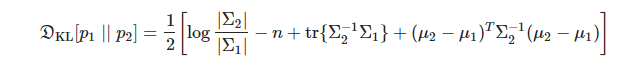

In [9]:
def multivariate_gaussian_D_js(train_mean, train_cov, target_mean, target_cov):
    return 0.5 * (multivariate_gaussian_D_kl(train_mean, train_cov, target_mean, target_cov) + multivariate_gaussian_D_kl(target_mean, target_cov, train_mean, train_cov))
        
def multivariate_gaussian_D_kl(mean1, cov1, mean2, cov2):
    d_kl=0
#     log_det1 = np.linalg.slogdet(cov1) # [value, sign]
#     log_det2 = np.linalg.slogdet(cov2)
    inv_cov2 = np.linalg.inv(cov2)
#     d_kl += log_det2[0] - log_det1[0]
    d_kl += np.log(np.abs(np.linalg.det(cov2)) / np.abs(np.linalg.det(cov1)))
    d_kl += -cov1.shape[0]
    d_kl += np.trace(np.matmul(inv_cov2, cov1))
    means_dif = mean2 - mean1
    d_kl += np.matmul(np.matmul(np.transpose(means_dif), inv_cov2), means_dif)

    return 0.5 * d_kl / np.log(2)

In [10]:
def propagate_rnn(start_time, steps, inputs, a, h, wI, wR, dtdivtau):
    samples = []
    h_t = []
    a_t = []
    for t in range(start_time, min(start_time + steps, inputs.shape[0]-1)):
        a, h = esn(inputs[t], a, h, wI, wR, dtdivtau)
        h_t.append(h)
        a_t.append(a)
        if (t - start_time) % SAMPLE_TIMESTEP == 0:#TODO add delta to remove start bias. todo - sample with random probability
            samples.append(a) # TODO activations vs state?
    return np.array(samples), h_t, a_t, a, h
        
def loss_function_batches(_wR, start_time, inputs, a_samples, h_samples, wI, _dtdivtau, target_mean, target_cov):
    samples = []
    for i in range(BATCHES_PER_GRADIENT):
        s, h_t, a_t, a, h = propagate_rnn(start_time, BATCH_SAMPLES * SAMPLE_TIMESTEP, inputs, a_samples[i], h_samples[i], wI, _wR, _dtdivtau)
        samples += list(s)
    return multivariate_gaussian_D_kl(np.mean(np.array(samples), axis=0), np.cov(np.array(samples).T), target_mean, target_cov), (h_t, a_t, a, h)

def loss_function_single_start(_wR, start_time, inputs, a, h, wI, _dtdivtau, target_mean, target_cov):
    samples, h_t, a_t, a, h = propagate_rnn(start_time, TRAIN_TIMESTEP, inputs, a, h, wI, _wR, _dtdivtau)
    return multivariate_gaussian_D_kl(np.mean(samples, axis=0), np.cov(samples.T), target_mean, target_cov), (h_t, a_t, a, h)

def esn_run_and_train_jax(params, x_t, target_mean=None, target_cov=None, opt_state=None, a_sample_tensor=None, do_train=False, step_size=1e-3):
  """Run the Echostate network forward a number of steps the length of x_t.
  
    This implementation uses JAX to build the outer time loop from basic
    Python for loop.

    Arguments: 
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of input time series, shape (t, u)
      f_t: ndarray of target time series, shape (t, m)
      do_train: Should the network be trained on this run? 
    
    Returns:
      4-tuple of params, fparams, h_t, z_t, after running ESN and potentially
        updating the readout vector.  
  """
  # per-example predictions
  a = params['a0']
  h = np.tanh(a)
  a_t = [a]  
  h_t = [h]
  loss = []

  wI = params['wI']
  wR = params['wR']
  dtdivtau = params['dt_over_tau']
  samples = []  
    
  j=0
  for t in tqdm.tqdm(range(0, x_t.shape[0] - 1, TRAIN_TIMESTEP)):
    if do_train:
        # TODO: very hacky to bypass the opt_update problem
        _, opt_update, get_params = optimizers.sgd(step_size)
        
        if TRAIN_TYPE == "batch":
            a_samples = a_sample_tensor[j]
            h_samples = np.tanh(a_samples) # TODO - switch a's and h's
            loss_function_batches(wR, t, x_t, a_samples, h_samples, wI, dtdivtau, target_mean, target_cov)
            loss_return_values , grads = value_and_grad(loss_function_batches, has_aux=True)(wR, t, x_t, a_samples, h_samples, wI, dtdivtau, target_mean, target_cov)
        else:
            loss_return_values , grads = value_and_grad(loss_function_single_start, has_aux=True)(wR, t, x_t, a, h, wI, dtdivtau, target_mean, target_cov)
        clipped_grads = optimizers.clip_grads(grads, np.square(wR.shape[0]))
        opt_state = opt_update(j, clipped_grads, opt_state)
        j+=1
        wR = get_params(opt_state)
        h_t += list(loss_return_values[1][0])
        a_t += list(loss_return_values[1][1])
        loss.append(loss_return_values[0])
    else:
        samples, h_t_new, a_t_new, a, h = propagate_rnn(t, TRAIN_TIMESTEP, x_t, a, h, wI, wR, dtdivtau)
        h_t += h_t_new
        a_t += a_t_new
        
        
  params['wR'] = wR
  h_t = np.array(h_t)
  a_t = np.array(a_t)
  
  return params, h_t, a_t, loss, opt_state

In [11]:
def esn_run_jax(params, x_t):
  """Run the echostate network forward.

    Arguments:
      params: dict of ESN params
      x_t: ndarray of input with shape (t,u)

    Returns: 
      2-tuple of ndarrays with first dim time, the hidden state and the outputs.
  """
  return esn_run_and_train_jax(params, x_t, None, None, None, None, do_train=False)

esn_run_jax_jit = jit(esn_run_jax)


def esn_train_jax(params, x_t, target_mean, target_cov, opt_state, a_sample_tensor, step_size):
  """Run the echostate network forward and also train it.

    Arguments:
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of inputs with shape (t,u)
      f_t: ndarray of targets with shape (t,m)

    Returns: 
      4-tuple of updated params, fparams, and also ndarrays with first dim 
        time, the hidden state and the outputs.
  """
  return esn_run_and_train_jax(params, x_t, target_mean, target_cov, opt_state, a_sample_tensor, do_train=True, step_size=step_size)
  
esn_train_jax_jit = jit(esn_train_jax)

In [12]:
# Basic parameters of the Echostate networks
key = random.PRNGKey(0)   
    
T = 160              # total time
u = 1               # number of inputs (didn't bother to set up zero, just put in zeros)
n = 5             # size of the reservoir in the ESN
tau = 1.0           # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

x_t = np.zeros((ntime,u)) # Just a stand-in in folks want a real input later
x_t = np.ones((ntime,u)) # Just a stand-in in folks want a real input later

TRAIN_TYPE = "batch"
BATCHES_PER_GRADIENT = 16
BATCH_SAMPLES = 10
SAMPLE_TIMESTEP = 1

if TRAIN_TYPE == "batch":
    TRAIN_TIMESTEP = BATCH_SAMPLES * SAMPLE_TIMESTEP * BATCHES_PER_GRADIENT
else:
    TRAIN_TIMESTEP = BATCH_SAMPLES * SAMPLE_TIMESTEP

# Data Analysis

In [428]:
import pickle
import seaborn as sns
sns.set()


def load_df(target_seed, run_id, g=5.5, I=1):
    with open("%s_seed%d__%d.pkl" % ("FR_train_output", target_seed, run_id), 'rb') as pkl:
        df = pickle.load(pkl)
        df.last_loss_js = df.last_loss_js.apply(lambda x: x[-1])
        df.best_loss_js = df.best_loss_js.apply(lambda x: x.item())
        df['wR'] = df['best_params'].apply(lambda x: x['wR'])
        df = df.sort_values('best_loss_js')
    

    key = random.PRNGKey(target_seed)
    target_data_params = random_esn_params(key, u, n, n, g=g, i=I)
    _, target_h, target_a, _, _ = esn_run_jax_jit(target_data_params, x_t)
    return df, target_data_params, target_h, target_a

def plot_new_params(target_h, target_data_params, wR, xlims=None, print=False):
    df, target_data_params, target_h, target_a = load_df(read_input_seed, read_run_id)   
    params = target_data_params.copy()
    params['wR']=wR
    m=n
    _, h_t, a_t, _, _ = esn_run_jax_jit(params, x_t)

    if print:
        fig = plt.figure(constrained_layout=True, figsize=(15, 4))
        gs = fig.add_gridspec(1, 2)
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.set_xlim((0, T))
        ax1.set_ylabel('Dimensions')
        ax1.set_xlabel('Time');
    #     ax1.set_title("best_D_js:%.02f, last_D_js:%.02f, corr=%.02f, distance=%.02f, normalized_distance=%.02f" % (df_record.best_loss_js, df_record.last_loss_js,
    #                                                                                                               df_record['corr'], df_record.distance, df_record.normalized_distance))
        ax1.plot(time, h_t + 2.5*onp.arange(0, m), 'g');
        if xlims is not None:
            ax1.set_xlim(*xlims)

        ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
        ax2.set_xlim((0, T))
        ax2.set_ylabel('Dimensions')
        ax2.set_xlabel('Time');
        ax2.set_title("target")
        ax2.plot(time, target_h + 2.5*onp.arange(0, m), 'r');

        plt.show()
        plt.pause(0.1)

    SAMPLE_TIMESTEP=1
    target_mean = np.mean(target_a[0::SAMPLE_TIMESTEP], axis=0) #TODO a\h
    target_cov = np.cov(target_a[0::SAMPLE_TIMESTEP].T)
    train_mean = np.mean(a_t[::SAMPLE_TIMESTEP], axis=0) #TODO a\h
    train_cov = np.cov(a_t[::SAMPLE_TIMESTEP].T)
    return multivariate_gaussian_D_js(train_mean, train_cov, target_mean, target_cov)
    
def plot_record(df_record, target_h, target_data_params, xlims=None):
    m=n
    _, h_t, a_t, _, _ = esn_run_jax_jit(df_record.best_params, x_t)

    fig = plt.figure(constrained_layout=True, figsize=(15, 4))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim((0, T))
    ax1.set_ylabel('Dimensions')
    ax1.set_xlabel('Time');
    ax1.set_title("best_D_js:%.02f, last_D_js:%.02f, corr=%.02f, distance=%.02f, normalized_distance=%.02f" % (df_record.best_loss_js, df_record.last_loss_js,
                                                                                                              df_record['corr'], df_record.distance, df_record.normalized_distance))
    ax1.plot(time, h_t + 2.5*onp.arange(0, m), 'g');
    if xlims is not None:
        ax1.set_xlim(*xlims)

    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax2.set_xlim((0, T))
    ax2.set_ylabel('Dimensions')
    ax2.set_xlabel('Time');
    ax2.set_title("target")
    ax2.plot(time, target_h + 2.5*onp.arange(0, m), 'r');

    plt.show()
    plt.pause(0.1)
    
    fig,ax = plt.subplots(ncols=2, figsize=(12, 4))
    sns.heatmap(df_record['wR'], center=0, vmin=-15, vmax=15, ax=ax[0], square=True)
    ax[0].set_title('learned')
    sns.heatmap(target_data_params['wR'], center=0, vmin=-15, vmax=15, ax=ax[1], square=True)
    ax[1].set_title('target')

In [166]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
from fastcluster import linkage

def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

In [400]:
from sklearn.cluster import AgglomerativeClustering

def analyze_data(read_input_seed, read_run_id, xlims=(0, T)):
    df, target_data_params, target_h, target_a = load_df(read_input_seed, read_run_id)
    plot_record(df.iloc[0], target_h, target_data_params, xlims=xlims)
    plt.figure()
    sns.scatterplot('best_loss_js', 'distance', data=df)
#     plt.figure()
#     sns.scatterplot('best_loss_js', 'normalized_distance', data=df)
    plt.figure()
    sns.scatterplot('best_loss_js', 'corr', data=df)
    
    print(df[['normalized_distance', 'distance']].corr())
    print(df[['corr', 'distance']].corr())
        
    return df

def analyze_clusters(df, number_of_values=None, metric='correlation', linkage='average', clusters=None):
    if number_of_values:
        number_of_values = df.shape[0]
    df = df.head(number_of_values)
    df['wR_flat'] = df.wR.apply(lambda x: x.flatten()[:,np.newaxis])
    mat = np.concatenate(list(df.wR_flat.values), 1)
    dist_mat = squareform(pdist(mat.T, metric))
    N=dist_mat.shape[0]

    plt.figure()
    plt.title('%s heatmap before sort' % (metric))
    plt.pcolormesh(dist_mat)
    plt.xlim([0,N])
    plt.ylim([0,N])
    plt.colorbar()
    plt.show()
    

    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat,linkage)
    plt.figure()
    plt.title('Ordered according to metric: %s' % (metric))
    plt.pcolormesh(ordered_dist_mat)
    plt.xlim([0,N])
    plt.ylim([0,N])
    plt.colorbar()
    plt.show()
    
    if clusters is not None:      
        s = AgglomerativeClustering(clusters, affinity=metric, linkage=linkage).fit(dist_mat.T)
        if linkage=='ward':
            linkage='average'
        plt.figure()
        sns.scatterplot('best_loss_js', 'corr', data=df, hue=s.labels_, legend='full', palette=sns.color_palette("hls", clusters))
        df['cluster'] = s.labels_
    
    return df
    

## First Target

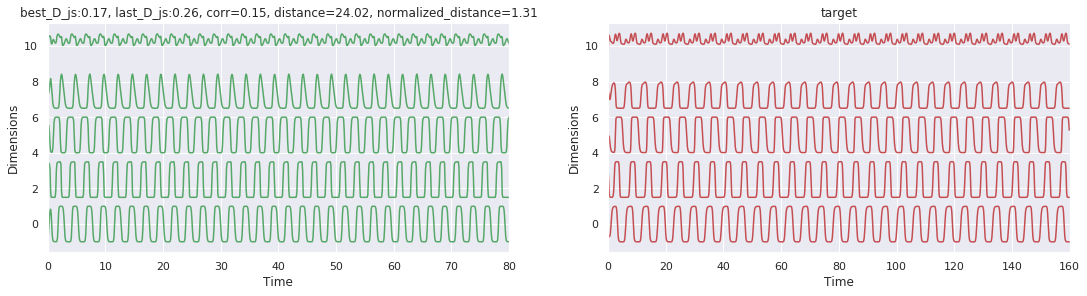

                     normalized_distance  distance
normalized_distance             1.000000  0.921394
distance                        0.921394  1.000000
              corr  distance
corr      1.000000 -0.921777
distance -0.921777  1.000000


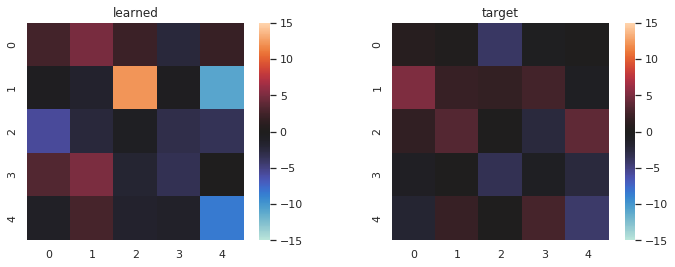

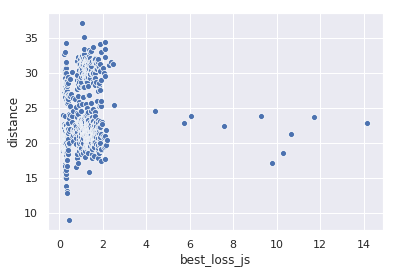

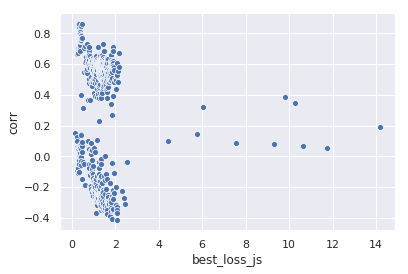

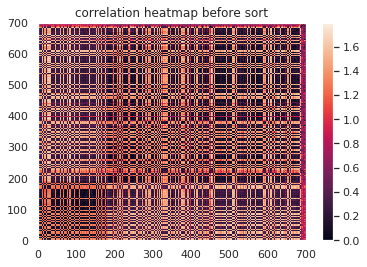

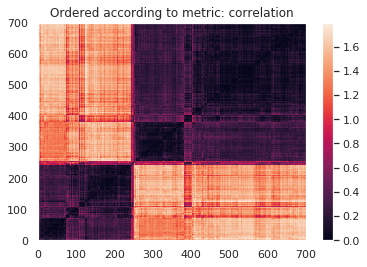

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/hierarchical.py:463: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


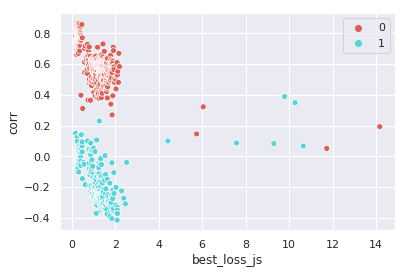

In [404]:
read_input_seed = 5597089
read_run_id = 656311

df1 = analyze_data(read_input_seed, read_run_id, xlims = [0,80])
df1 = analyze_clusters(df1, metric='correlation', clusters=2)
# analyze_clusters(df1, metric='euclidean', clusters=2)
# analyze_clusters(df1, metric='cosine', , clusters=2)

In [420]:
wR0 = df1[(df1.best_loss_js<2) & (df1.cluster==0)].iloc[0].wR
wR1 = df1[(df1.best_loss_js<2) & (df1.cluster==1)].iloc[0].wR

In [367]:
np.corrcoef(wR0.flatten(), wR1.flatten())

array([[ 1.        , -0.20529203],
       [-0.20529203,  1.        ]])

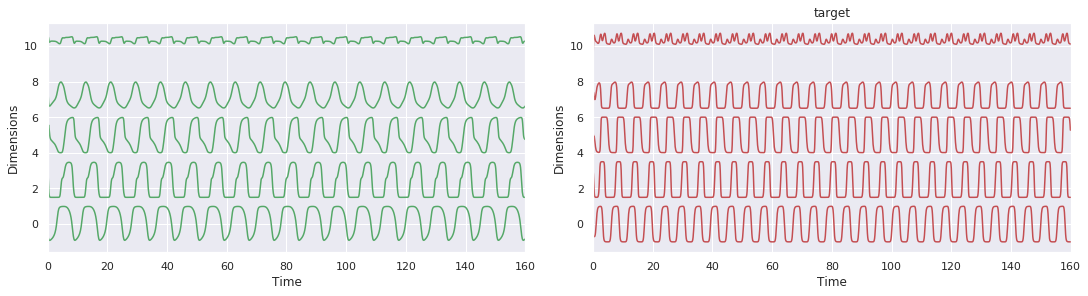

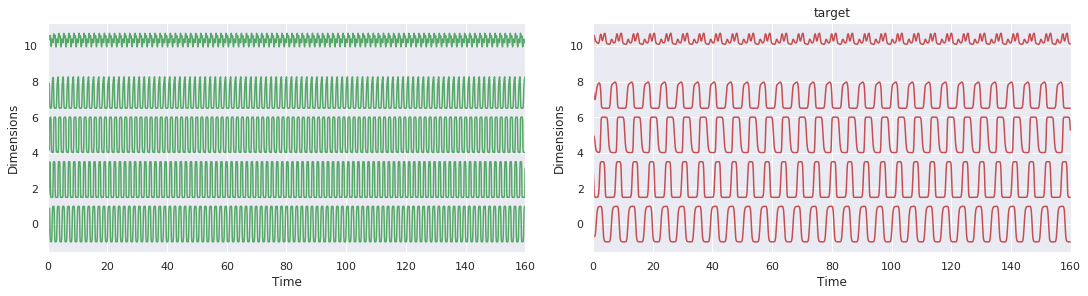

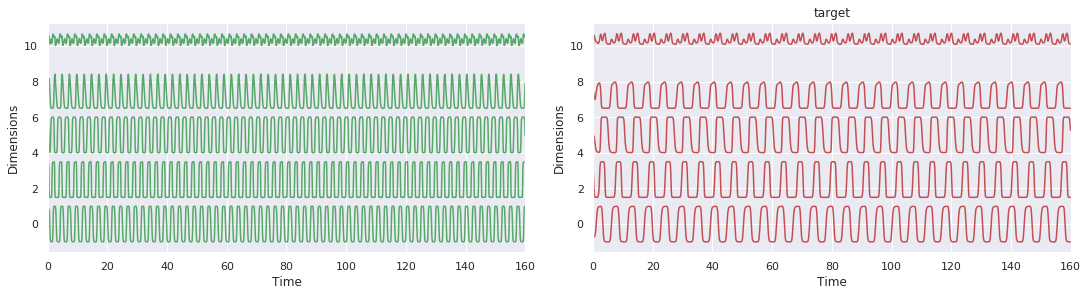

0.17820794477191976

In [469]:
wR0 = cluster0.iloc[0].wR
wR1 = cluster1.iloc[0].wR
plot_new_params(read_input_seed, read_run_id, wR = (wR1+wR0)/2, print=True)
plot_new_params(read_input_seed, read_run_id, wR = wR0, print=True)
plot_new_params(read_input_seed, read_run_id, wR = wR1, print=True)

In [ ]:
losses = []
weights_ratios = []
weights_corrs = []

cluster0 = df1[(df1.best_loss_js<2) & (df1.cluster==0)]
cluster1 = df1[(df1.best_loss_js<2) & (df1.cluster==1)]
for i,j in itertools.product(range(cluster0.shape[0]), range(cluster0.shape[1])):
    wR0 = cluster0.iloc[i].wR
    wR1 = cluster1.iloc[j].wR
    losses.append(plot_new_params(read_input_seed, read_run_id, wR = (wR1+wR0)/2, print=False))
    weights_ratios.append(max(np.linalg.norm(wR0.flatten())/np.linalg.norm(wR1.flatten()), 
                              np.linalg.norm(wR1.flatten())/np.linalg.norm(wR0.flatten())))
    weights_corrs.append(np.corrcoef(wR0.flatten(), wR1.flatten())[0][1])

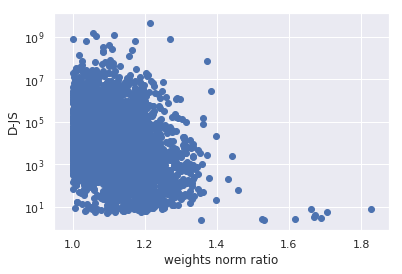

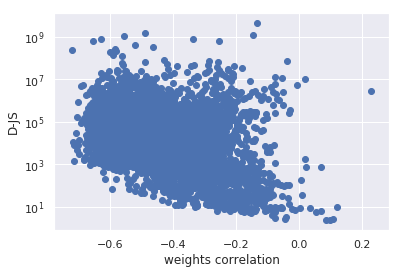

In [452]:
plt.scatter(weights_ratios, losses)
plt.xlabel('weights norm ratio')
plt.ylabel('D-JS')
# plt.ylim((0, scipy.stats.median_absolute_deviation(losses)*2))
plt.yscale("log")
plt.figure()
plt.scatter(weights_corrs, losses)
plt.xlabel('weights correlation')
plt.ylabel('D-JS')
plt.yscale("log")
# plt.ylim((0, scipy.stats.median_absolute_deviation(losses)*2))

(0, 1000)

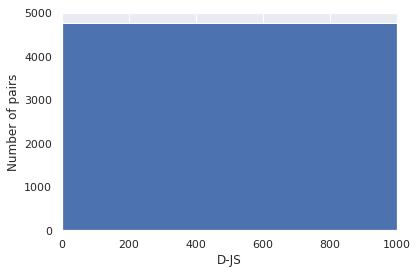

In [465]:
plt.hist(losses,150)
plt.xlabel("D-JS")
plt.ylabel('Number of pairs')
plt.xlim((0, 1000))
# plt.xscale("log")

(0, 100)

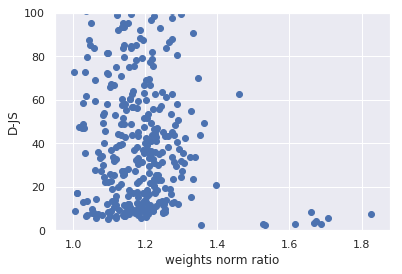

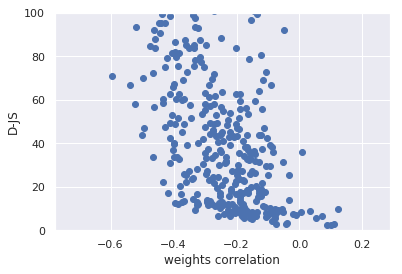

In [450]:
plt.scatter(weights_ratios, losses)
plt.xlabel('weights norm ratio')
plt.ylabel('D-JS')
plt.ylim((0, 100))
plt.figure()
plt.scatter(weights_corrs, losses)
plt.xlabel('weights correlation')
plt.ylabel('D-JS')
plt.ylim((0, 100))

## Second Target

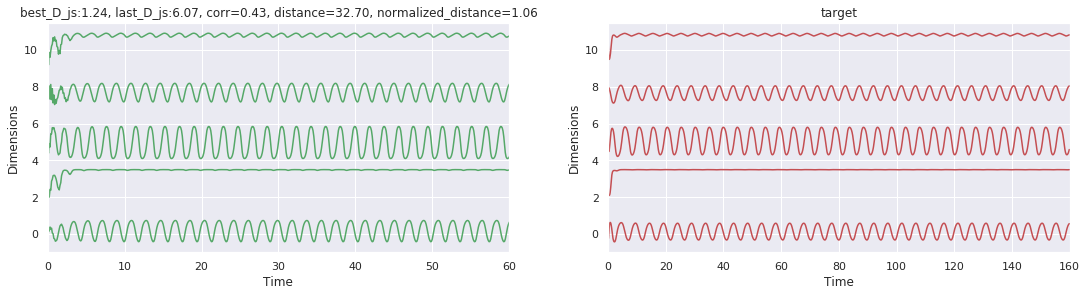

                     normalized_distance  distance
normalized_distance              1.00000   0.05654
distance                         0.05654   1.00000
              corr  distance
corr      1.000000 -0.258831
distance -0.258831  1.000000


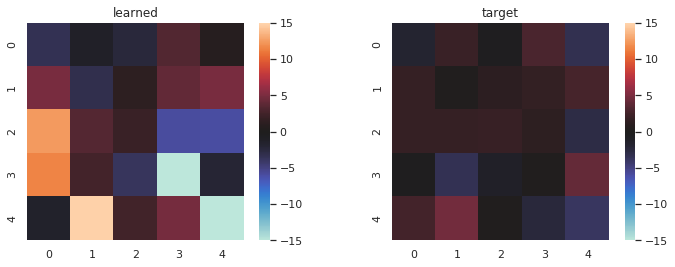

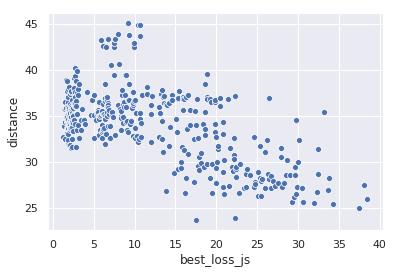

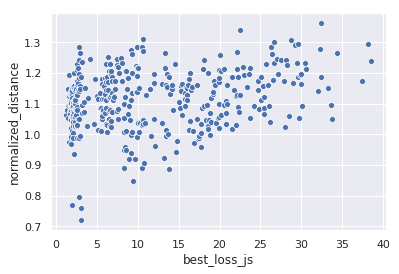

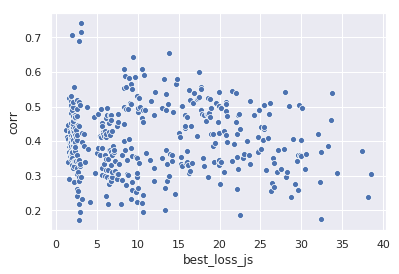

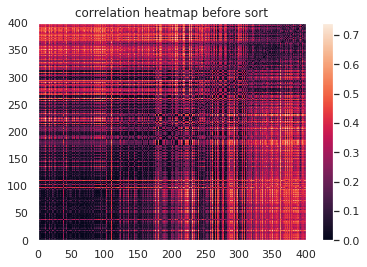

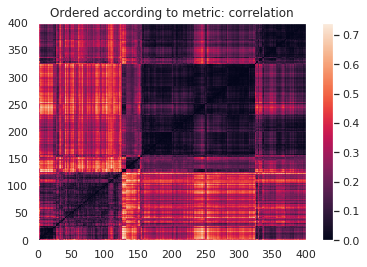

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/hierarchical.py:463: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


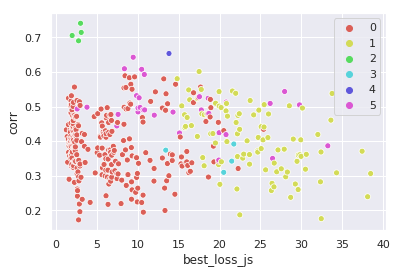

In [346]:
read_input_seed = 566803
read_run_id = 7665

df2 = analyze_data(read_input_seed, read_run_id, xlims = [0,60])
analyze_clusters(df2, metric='correlation', linkage='average', clusters=6)

## Third Target

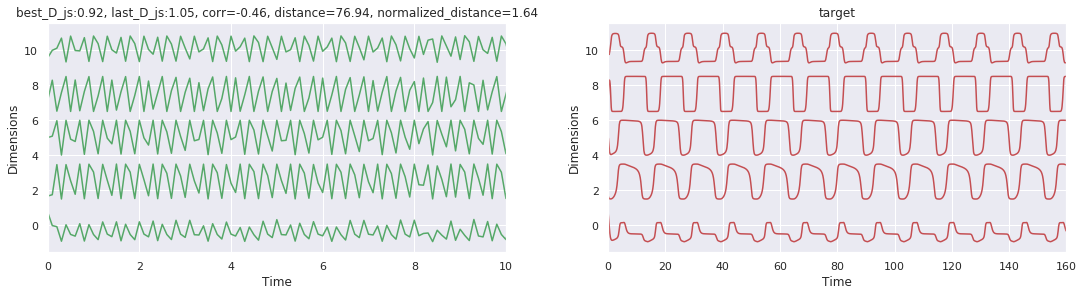

                     normalized_distance  distance
normalized_distance             1.000000  0.428858
distance                        0.428858  1.000000
              corr  distance
corr      1.000000 -0.414239
distance -0.414239  1.000000


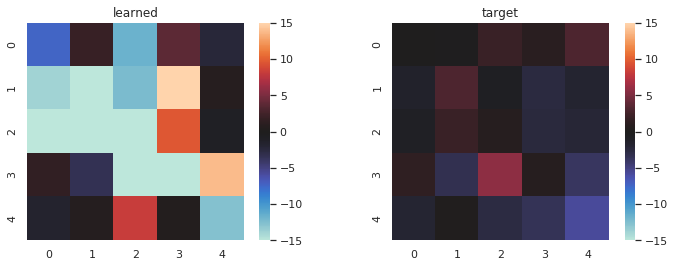

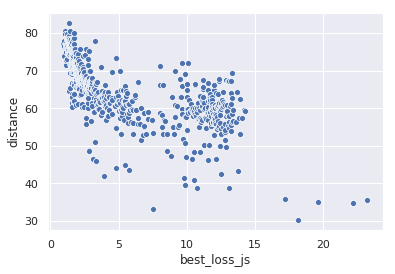

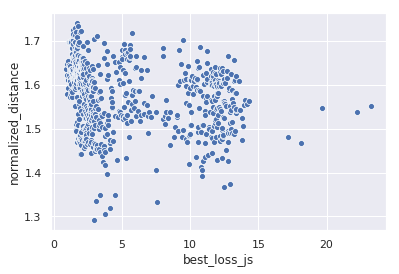

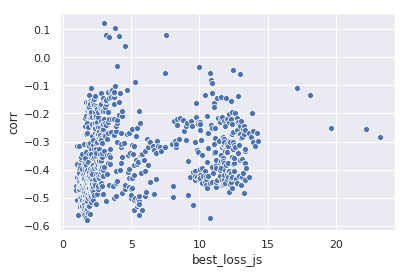

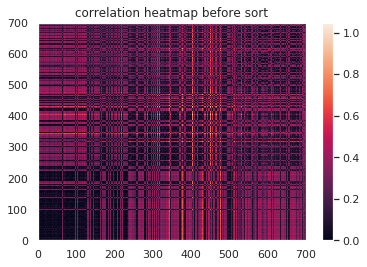

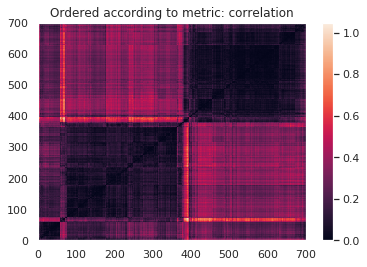

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/hierarchical.py:463: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


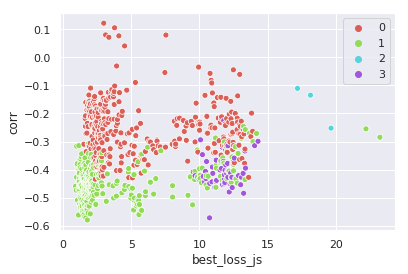

In [347]:
read_input_seed = 9326695
read_run_id = 454543

df3 = analyze_data(read_input_seed, read_run_id, xlims = [0,10])
analyze_clusters(df3, metric='correlation', linkage='average', clusters=4)